# Исследование взаимодействия с клиентами фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

#### Описание данных
Таблица `/datasets/gym_churn.csv`:

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
-`Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

# Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
#Функция для чтения таблиц
def read_table(name):
    pth1 = '/datasets/' + name + '.csv'
    pth2 = 'C:\\Users\\user\YandexDisk\Data analyst Yandex 2022\Проекты\Project_11 (ML)\\' + name + '.csv'
    pth3 = 'F:\\YandexDisk\\Data analyst Yandex 2022\\Проекты\\Project_11 (ML)\\' + name +'.csv'

    if os.path.exists(pth1):
        table = pd.read_csv(pth1, sep=',')
    elif os.path.exists(pth2):
        table = pd.read_csv(pth2, sep=',')
    elif os.path.exists(pth3):
        table = pd.read_csv(pth3, sep=',')
    else:
        raise FileNotFoundError()
        return
    return table

#Читаем датасет
data = read_table('gym_churn')

In [3]:
#общая информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
#первые пять строк
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
#проверяем на наличие явных дубликатов
data.duplicated().sum()

0

In [6]:
#проверяем на наличие неявных дубликатов
for feature in data.loc[:, 'gender':'Age'].columns:
    display(data[feature].value_counts())

1    2041
0    1959
Name: gender, dtype: int64

1    3381
0     619
Name: Near_Location, dtype: int64

0    2053
1    1947
Name: Partner, dtype: int64

0    2766
1    1234
Name: Promo_friends, dtype: int64

1    3614
0     386
Name: Phone, dtype: int64

1     2207
12     960
6      833
Name: Contract_period, dtype: int64

0    2351
1    1649
Name: Group_visits, dtype: int64

29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: Age, dtype: int64

# Шаг 2. Исследовательский анализ данных

In [7]:
#изучим распределения по признакам датасета
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Можно выделить следующие факты:
- Мужчины и женщины в пропорции почти 50 на 50.
- Живут или работают рядом с фитнес-центром 85%.
- Почти половина клиентов - сотрудники компаний-партнеров. 
- 30% всех клиентов пришли по акции "Приведи друга".
- Телефон указан у 90% клиентов.
- Средний абонемент 4,7 месяца, медианный 1 месяц.
- 41% посещал групповые занятия. 
- Средний и медианный возраст клиентов 29 лет.

In [8]:
#Посмотрим на средние значения признаков по группам оставшихся и в оттоке
data.groupby('Churn').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Обнаруженные основные зависимости:
- Факт оттока не зависит от пола клиента. 
- Чуть чаще уходят те, кто не работает или не живет рядом с фитнес-центром.
- Чуть чаще уходят те, кто не работает в компаниях-партнерах.
- Чаще уходят клиенты с короткими абонементами.
- Посетившие групповые занятия уходят реже.
- Средний возраст клиента в оттоке ниже.
- Чаще уходят клиенты с малым лайфтаймом и те, кто редко посещал.

Построим столбчатые гистограммы для категориальных признаков и гистограммы распределения для числовых.

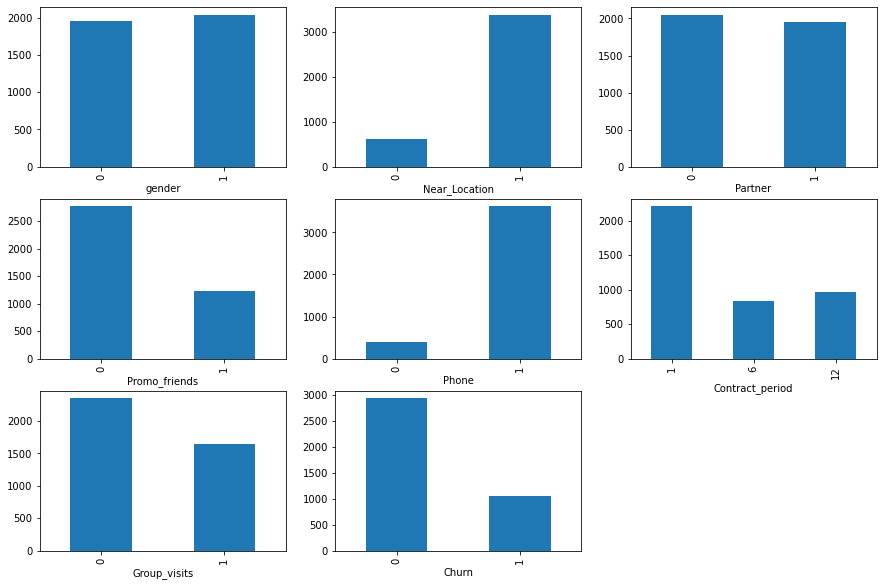

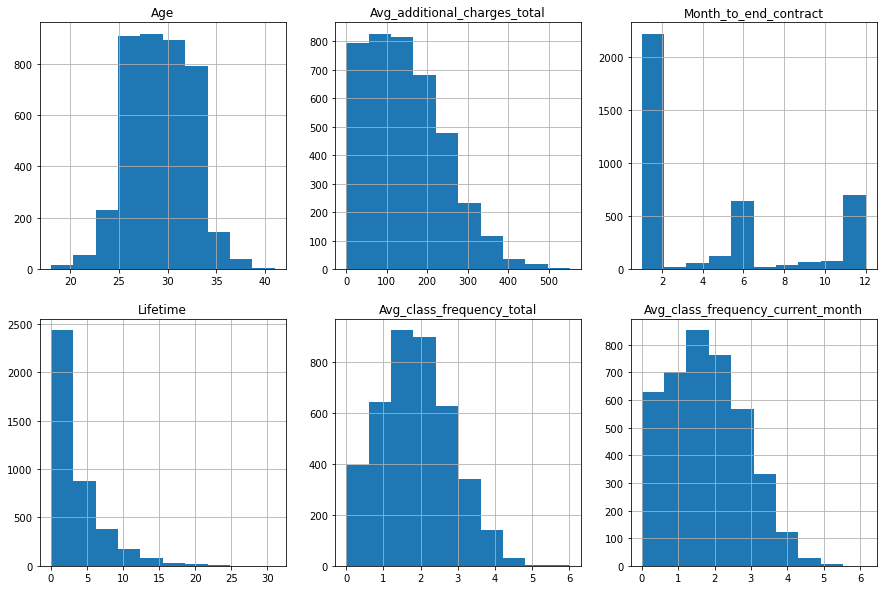

In [9]:
#классифицируем признаки
categorial = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits', 'Churn']
numeric = ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

#обрабатываем категориальные признаки
plt.figure(figsize=(15, 10))
for i in range(len(categorial)):
    ax = plt.subplot(3, 3, i+1)
    data.pivot_table(index=categorial[i], values='Age', aggfunc='count').plot(kind='bar', legend=False, ax=ax) 
plt.show()

#обрабатываем числовые признаки
plt.figure(figsize=(15, 10))
for i in range(len(numeric)):
    ax = plt.subplot(2, 3, i+1)
    data[numeric[i]].hist(ax=ax)
    plt.title(numeric[i])
plt.show()

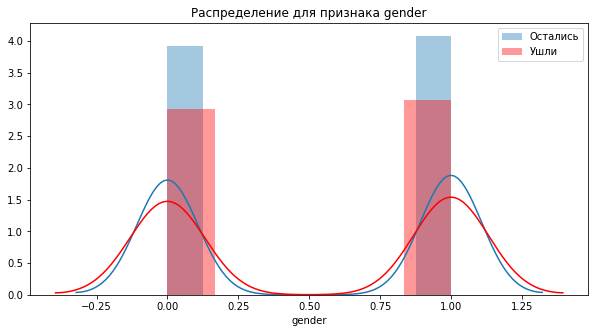

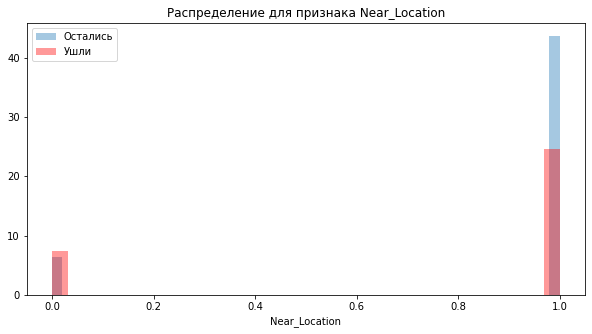

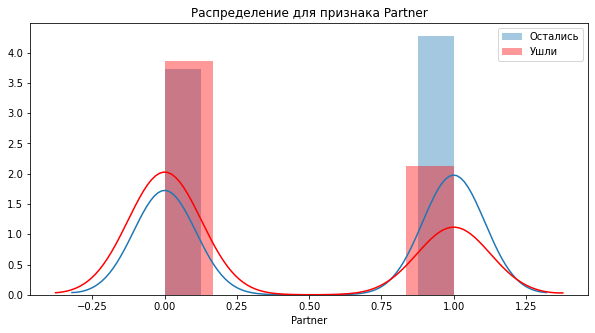

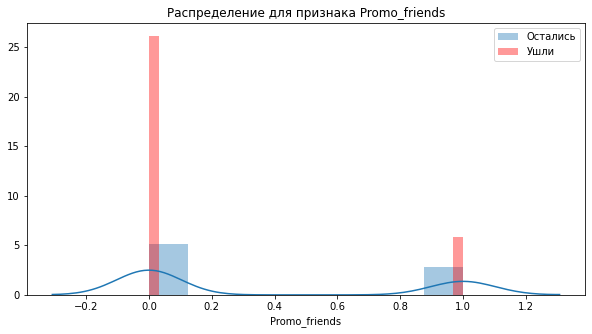

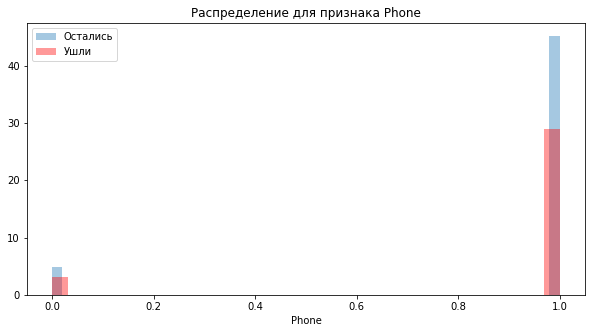

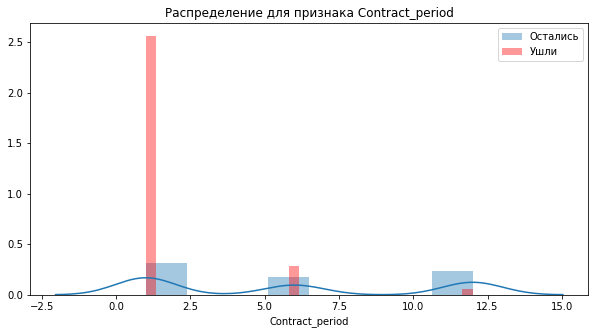

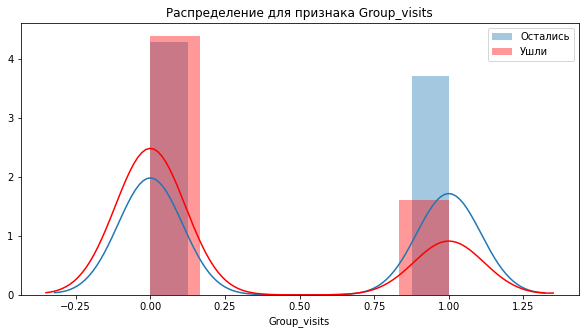

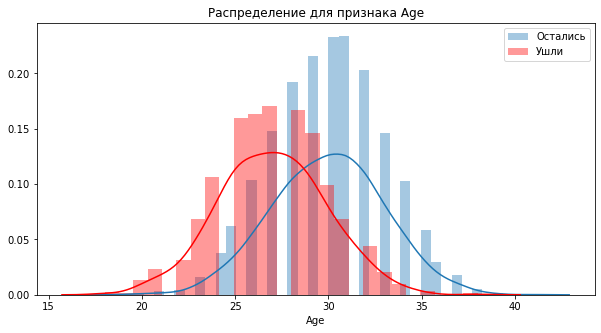

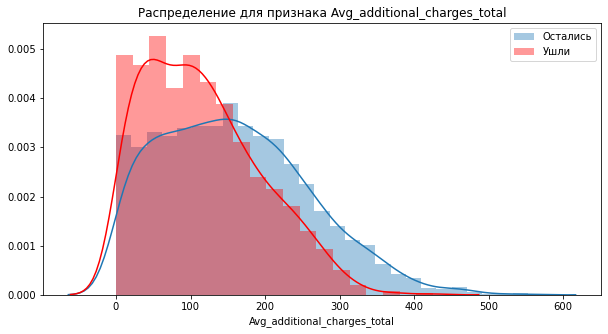

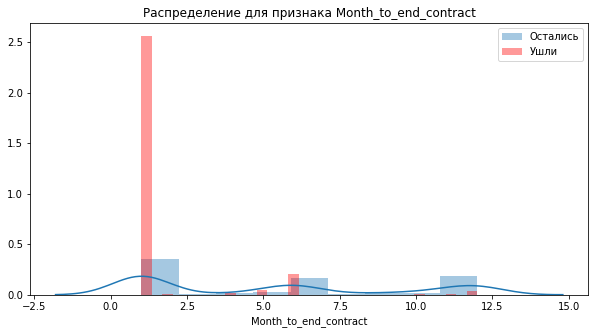

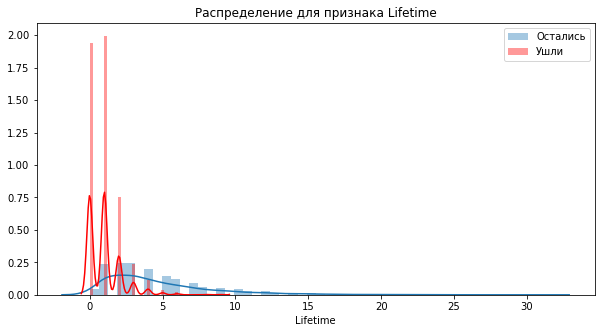

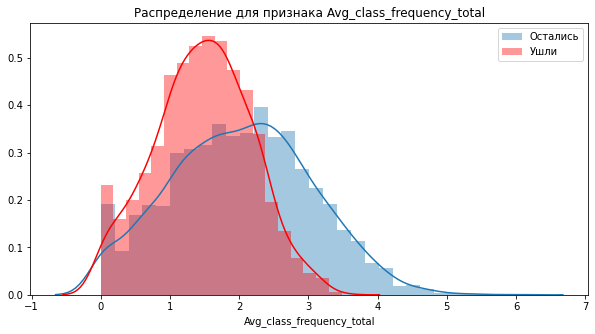

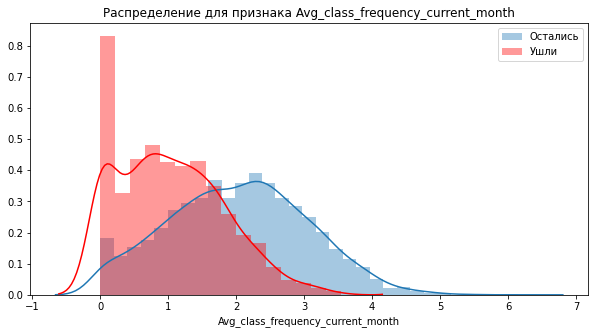

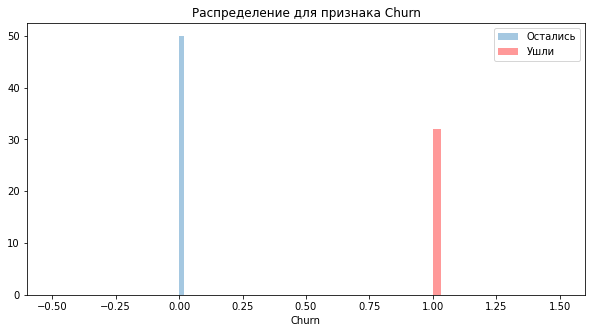

In [10]:
#Доработка
import warnings
warnings.filterwarnings('ignore') #убираю предупреждение python

int_features = data.columns

for col in int_features:
    plt.figure(figsize=(10, 5))
    sns.distplot(data.query('Churn==0')[col])
    sns.distplot(data.query('Churn!=0')[col], color = 'r')
    plt.legend(labels = ('Остались', 'Ушли'))
    plt.title('Распределение для признака ' + col)
    plt.show()

Данные получены и готовы к анализу. Дубликатов не обнаружено. Аномалий также не замечено, распределение числовых признаков на гистограммах визуально выглдит близким к нормальному. Гистограммы категорианых признаков подтверждают ранее сделанные выводы о данных.

Построим матрицу и хитмэп корреляций между признаками.

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


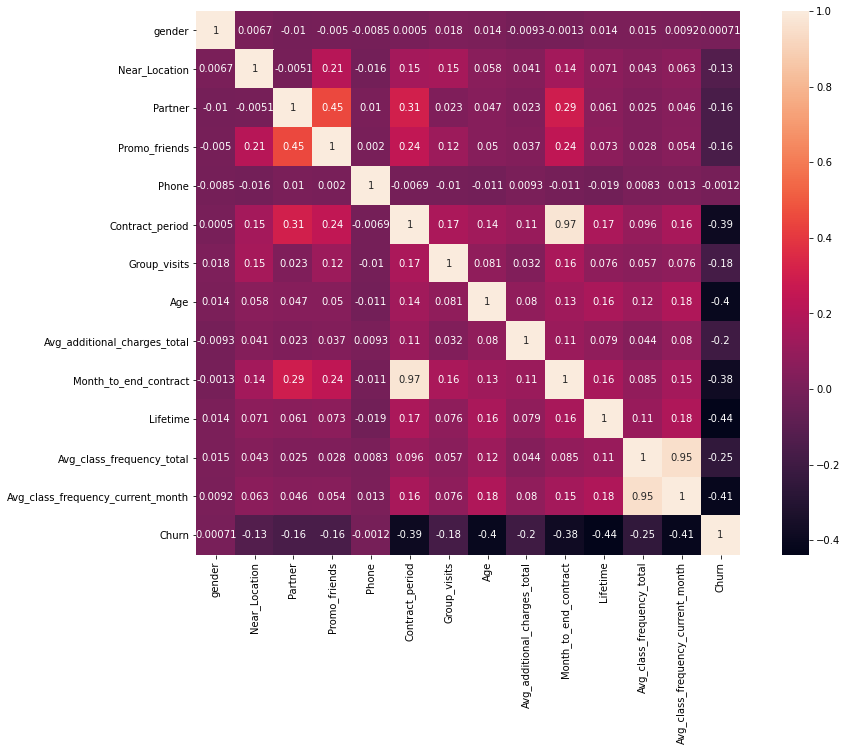

In [11]:
#матрица корреляций
cm = data.corr()
display(cm)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, square=True)
plt.show()

Сильных взаимных корреляций между признаками нет. Значения колеблются от -0,44 до +0,45. Это значит, что лишних для линейных моделей машинного обучения признаков в данных нет.

# Шаг 3. Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Используем два алгоритма - логистической регрессии и случайного леса.

In [12]:
#Разделяем данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['Churn'])
y = data['Churn']

#Разбиваем данные на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Обучаем модели train-выборкой по алгоритмам логистической регрессии и случайного леса (количество сдвигов оценки = 100)
lr_model = LogisticRegression(solver='liblinear', random_state=0)
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

#Формируем векторы предсказаний
lr_y_pred = lr_model.predict(X_test)
rf_y_pred = rf_model.predict(X_test)

Рассчитаем метрики для обоих моделей.  

In [13]:
print('Logistic regression')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_y_pred)))
print('Random forest regression')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_y_pred)))

Logistic regression
Accuracy: 0.93
Precision: 0.86
Recall: 0.83
Random forest regression
Accuracy: 0.92
Precision: 0.84
Recall: 0.82


Лучше показал себя алгоритм логистической регрессии, его метрики немного выше.

# Шаг 4. Выполним кластеризацию клиентов

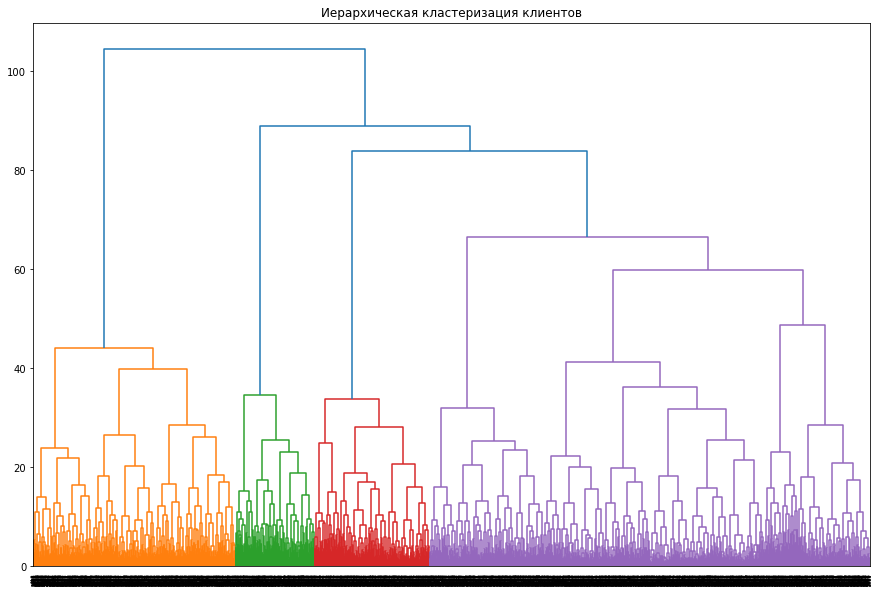

In [14]:
#Стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#Строим дендрограмму
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов')
plt.show() 

На основании дендрограммы оптимально выделить от 4 до 6 кластеров. Остановимся на 5. Построим модель кластеризации с применением алгоритма K-Means с n=5.

In [15]:
km = KMeans(n_clusters=5, random_state=0)
# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_sc)
#добавляем в отдельный столбец датасета метки кластеров
data['cluster'] = labels
#группируем данные по кластерам, чтобы взглянуть на средние значения признаков
data.groupby('cluster').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
1,0.480787,0.812559,0.000000,0.086223,1.000000,1.866917,0.325211,28.145267,131.369042,1.791003,2.345829,1.325865,1.086883,0.550141
2,0.559567,0.858002,0.338147,0.197353,0.998797,2.730445,0.448857,30.196149,164.579011,2.519856,5.010830,2.928140,2.934140,0.048135
3,0.509603,0.750320,1.000000,0.451985,1.000000,2.554417,0.303457,28.499360,129.812508,2.370038,2.832266,1.355379,1.176172,0.395647
4,0.495726,0.943376,0.752137,0.541667,1.000000,11.352564,0.564103,29.993590,164.563799,10.376068,4.817308,2.028169,2.020129,0.023504


Наблюдения:
- 1 и 3 кластеры отличаются тем, что клиенты не являются и являются сотрудниками компаний-партнеров соответственно. Очевидно, эти кластеры на одной ветви дендрограммы.
- в 1м кластере у всех клиентов в базе нет номеров телефонов, во всех остальных почти у всех есть.
- в 4м кластере большинство - годовые абонементы, в 1м - наибольшее количество одномесячных абонементов.

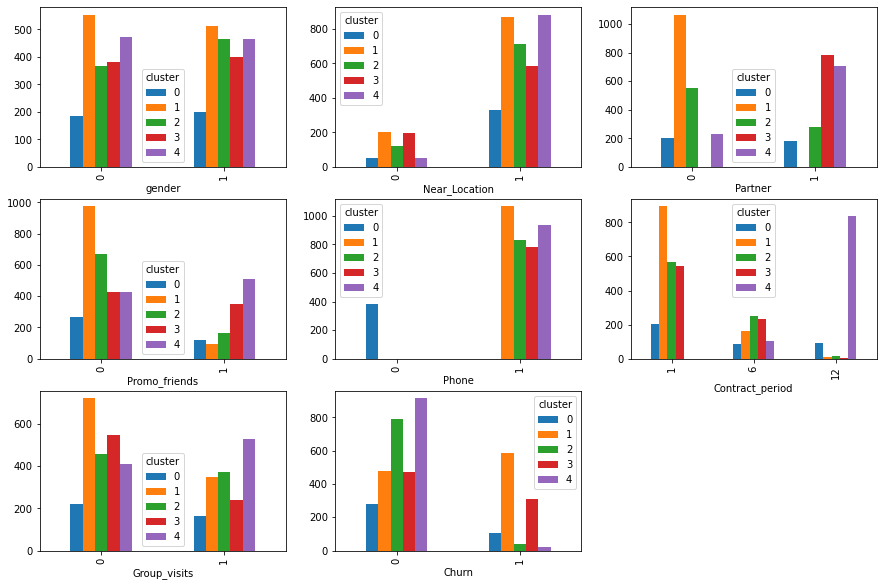

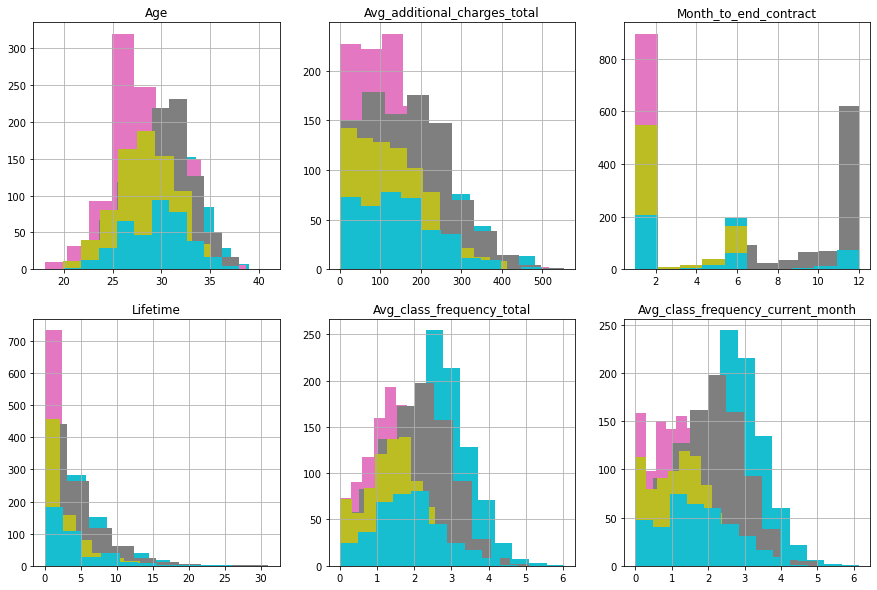

In [16]:
#обрабатываем категориальные признаки
plt.figure(figsize=(15, 10))
for i in range(len(categorial)):
    ax = plt.subplot(3, 3, i+1)
    data.pivot_table(index=categorial[i], columns='cluster', values='Age', aggfunc='count').plot(kind='bar', legend=True, ax=ax) 
plt.show()

#обрабатываем числовые признаки
plt.figure(figsize=(15, 10))
for i in range(len(numeric)):
    ax = plt.subplot(2, 3, i+1)
    for cluster in labels:
        data.query('cluster == @cluster')[numeric[i]].hist(ax=ax)
    plt.title(numeric[i])
plt.show()

Наблюдения:
- все наблюдения, высказанные выше, подтверждаются графиками.
- высокое значение promo_friends в 1м кластере одновременно с фактом не принадлежности к компанями-партнерам
- именно в этом же кластере зафиксирован наибольший процент оттока
- на втором месте по оттоку 3й кластер. Этот кластер характеризуется 100% клиентов-сотрудников компаний-партнеров.
- 1й и 3й кластер характеризуются также самым низким средним lifetime
- клиенты 1го и 3го кластеров также редко посещают групповые занятия
- наиболее лояльные клиенты - клиенты с большим сроком абонемента
- распределения числовых признаков по кластерам не отличаются значимо

Для каждого полученного кластера посчитаем долю оттока.

In [18]:
data.groupby('cluster').agg('mean')['Churn']

cluster
0    0.267532
1    0.550141
2    0.048135
3    0.395647
4    0.023504
Name: Churn, dtype: float64

Действительно, 1й и 3й кластер имеют наибольшие доли оттока. При этом в этих кластерах также довольно низкий средний срок абонемента.

# Выводы и рекомендации

По полученным результатам можно резюмировать, что наиболее часто отток происходит, когда клиент приходит по акции "Приведи друга", а также из компании партнера. Эти клиенты чаше имеют короткие сроки абонементов и многие из них не посящаю групповые занятия. Возможно, первый абонемент доставался им по промо-цене, а к повышению цены они не готовы.

Рекомендации:
- Улучшить освещение работы групповых занятий, поработать над их программой, для достижения большей вовлеченности клиента и его мотивации
- Пересмотреть условия акции "Приведи друга". Увеличить срок действия промо абонемента. Начислять бонусное время за определенное количество посещений.
- Предложить специальные условия для сотрудников компаний-парнеров
- Расширять круг компаний-партнеров 